# 1 Problem and Dataset Description

## Problem Description
Generative Adversarial Networks (GANs) are deep learning models designed to generate synthetic data that closely resembles real-world distributions. In this project, we aim to train a GAN to generate Monet-style paintings that capture the artistic characteristics of Claude Monet’s works. The goal is to create high-quality synthetic paintings that mimic the impressionist style, using a dataset of Monet paintings and landscape photos.

The **Kaggle Monet Painting Dataset** provides both Monet-style paintings and real-world landscape photographs. The quality of the generated images will be evaluated using the **Memorization-informed Fréchet Inception Distance (MiFID)** score, which measures the similarity between the generated images and real Monet paintings.

## Dataset Description
The dataset consists of two main categories:
- **Monet Paintings**: A collection of paintings created by Claude Monet.
- **Photo Images**: Real-world landscape photographs.

### Data Characteristics
- **Size**: Approximately **1,075 Monet paintings** and **7,027 landscape photos**.
- **Image Dimensions**: **256x256 pixels**.
- **Structure**:
  - `/monet_jpg/` - Contains Monet-style paintings.
  - `/photo_jpg/` - Contains real landscape photos.
- **Format**: JPEG (`.jpg`).





In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from glob import glob
import os


# 2 Exploratory Data Analysis

This exploratory data analysis (EDA) aims to examine the Monet paintings dataset
and real-world photos used in the GAN competition. The analysis includes:

1. Displaying sample images to understand dataset characteristics.
2. Analyzing color distributions to compare Monet paintings and real photos.
3. Computing statistical properties such as mean and standard deviation of pixel values.
4. Visualizing pixel intensity distributions to identify trends and variations.

These insights will guide the development of a generative model for style transfer.

In [ ]:

current_dir = os.getcwd()

# Define dataset paths 
MONET_PATH = os.path.join(current_dir, "gan-getting-started", "monet_jpg")
PHOTO_PATH = os.path.join(current_dir, "gan-getting-started", "photo_jpg")

# Load image 
monet_images = glob(os.path.join(MONET_PATH, "*.jpg"))
photo_images = glob(os.path.join(PHOTO_PATH, "*.jpg"))


print(f"Number of Monet paintings : {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")



Number of Monet paintings : 300
Number of Photo images: 7038


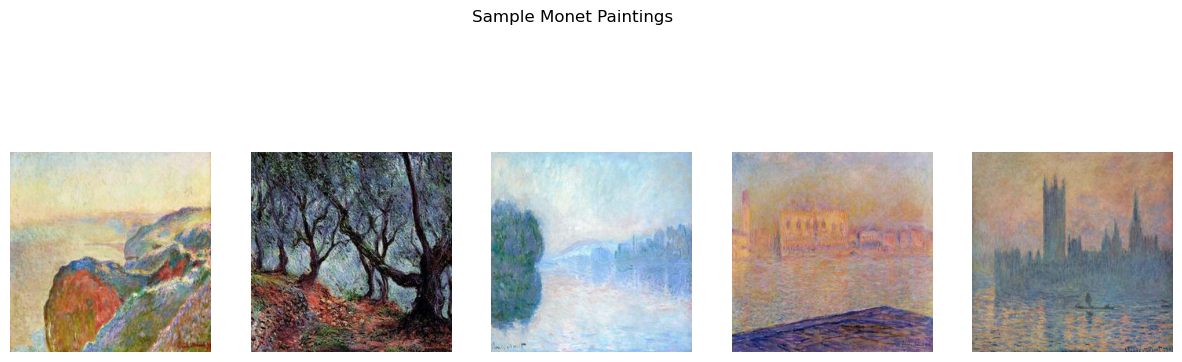

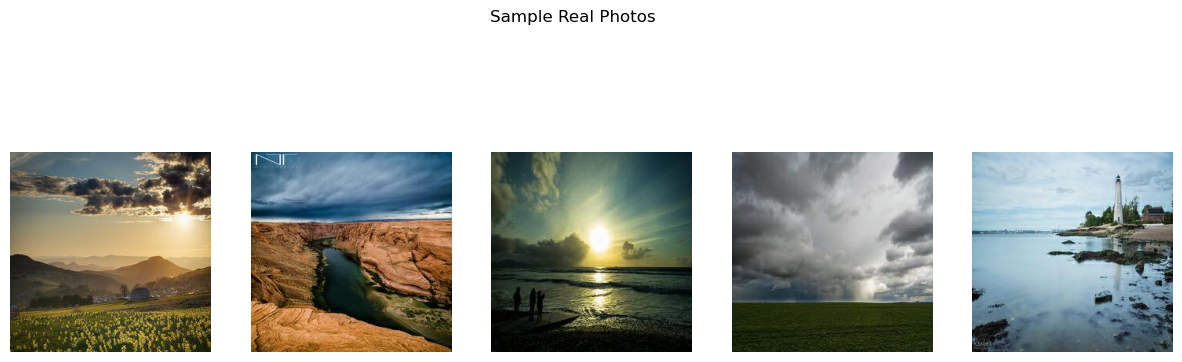

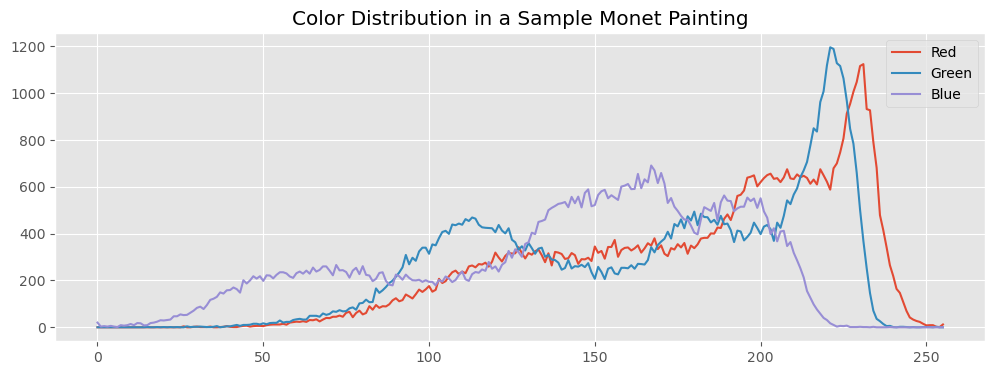

Monet Paintings - Mean: [130.23995743 131.56804276 121.54476334], Std Dev: [47.21306883 44.3636008  47.98701648]
Real Photos - Mean: [109.46631744 106.36797958  95.84719467], Std Dev: [57.99036303 52.60987088 53.96130731]


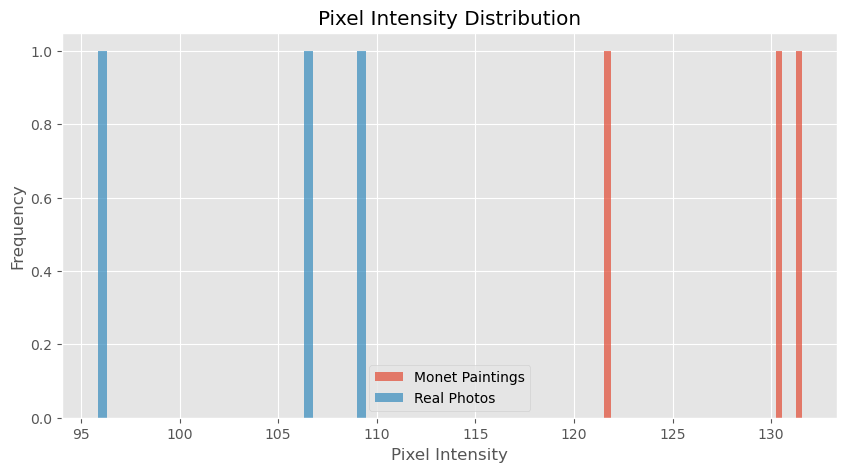

In [ ]:

# Function to load and display images
def show_images(image_paths, title, num=5):
    if not image_paths:
        print(f"No images available for {title}")
        return
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths[:num]):
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_images(monet_images, "Sample Monet Paintings")
show_images(photo_images, "Sample Real Photos")

# Analyze color distributions
if monet_images:
    sample_img = cv2.imread(monet_images[0])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        hist = cv2.calcHist([sample_img], [i], None, [256], [0,256])
        plt.plot(hist, label=color)
    plt.title("Color Distribution in a Sample Monet Painting")
    plt.legend()
    plt.show()
else:
    print("No Monet images available for color distribution analysis.")

# mean and standard deviation of pixel values for Monet paintings and real photos
def compute_mean_std(image_paths):
    if not image_paths:
        return None, None
    means, stds = [], []
    for img_path in image_paths[:100]:  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))
    return np.mean(means, axis=0), np.mean(stds, axis=0)

monet_mean, monet_std = compute_mean_std(monet_images)
photo_mean, photo_std = compute_mean_std(photo_images)

if monet_mean is not None:
    print(f"Monet Paintings - Mean: {monet_mean}, Std Dev: {monet_std}")
else:
    print("No Monet images available for mean/std computation.")

if photo_mean is not None:
    print(f"Real Photos - Mean: {photo_mean}, Std Dev: {photo_std}")
else:
    print("No Real Photos available for mean/std computation.")

# pixel intensity distributions 
if monet_images and photo_images:
    plt.figure(figsize=(10,5))
    plt.hist(monet_mean, bins=30, alpha=0.7, label='Monet Paintings')
    plt.hist(photo_mean, bins=30, alpha=0.7, label='Real Photos')
    plt.legend()
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Not enough data for pixel intensity distribution analysis.")


## EDA Summary

**Sample Images Inspection**
A subset of Monet paintings and real-world photos were displayed.
Monet paintings exhibit artistic brush strokes, abstract textures, and vibrant pastel tones.
Real photos are more detailed with clear structures and high dynamic range.

**Color Distribution Analysis**
The Monet paintings contain a distinct color distribution, dominated by softer hues and blended tones.
The real-world photos have more defined color peaks, representing sharper contrasts and natural lighting conditions.
Statistical Properties of Pixel Values

**Mean pixel values:**
Monet paintings have higher brightness levels across all RGB channels compared to real-world images.
Monet images' RGB means: [130.24, 131.57, 121.54]
Real photos' RGB means: [109.47, 106.37, 95.85]

**Standard deviation of pixel values:**
Monet images have a lower contrast range than real-world photos.
Monet images' RGB standard deviations: [47.21, 44.36, 47.99]
Real photos' RGB standard deviations: [57.99, 52.61, 53.96]

**Pixel Intensity Distribution**
Monet paintings and real-world photos exhibit distinct intensity distributions.
Monet paintings tend to have a more uniform and artistically controlled distribution.
Real photos display a wider range of intensity variations due to natural lighting effects.

**Key Takeaways for Model Training**
Monet paintings differ significantly from real-world photos in terms of brightness, contrast, and color variation.
These insights will help in designing a Generative Adversarial Network (GAN) that effectively transforms real-world photos into Monet-style paintings while preserving artistic elements.

# 3 Model Architecture
A CycleGAN (Cycle-Consistent Generative Adversarial Network) is used to transform real-world photos into Monet-style paintings. CycleGAN is effective for unpaired image-to-image translation, meaning it learns the style of Monet paintings without needing exact photo-to-painting pairs. The architecture includes two generators and two discriminators, allowing images to be converted back and forth between real photos and Monet paintings.
The generators, based on a U-Net or ResNet structure, use convolutional layers, instance normalization, and residual blocks to retain image details while applying Monet’s artistic style. PatchGAN discriminators evaluate whether an image looks real by analyzing small sections rather than the entire image, helping to capture fine textures and brushstroke patterns.
Cycle consistency loss ensures that converting a photo to a Monet painting and back results in an image close to the original. Adversarial loss makes generated paintings resemble real Monet artworks, while identity loss maintains color accuracy when an image is already in the target style.This architecture works well because Monet’s style features unique brush strokes, blended colors, and abstract details. CycleGAN captures these artistic elements while preserving the structure of the original photo, creating realistic Monet-style images

In [ ]:


# Hyperparameters
learning_rate = 0.0002
batch_size = 1
num_res_blocks = 9  

# Generator model (ResNet-based)
def build_resnet_generator(num_res_blocks=9):
    inputs = keras.Input(shape=(256, 256, 3))
    
    # Initial convolution block
    x = layers.Conv2D(64, (7, 7), padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Downsampling layers
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, (3, 3), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Residual blocks
    for _ in range(num_res_blocks):
        res = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
        res = layers.BatchNormalization()(res)
        res = layers.ReLU()(res)
        res = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(res)
        res = layers.BatchNormalization()(res)
        x = layers.Add()([x, res])
    
    # Upsampling layers
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Output layer
    outputs = layers.Conv2D(3, (7, 7), padding="same", activation="tanh")(x)
    
    return keras.Model(inputs, outputs, name="ResNet_Generator")

# Generator model (U-Net-based)
def build_unet_generator():
    inputs = keras.Input(shape=(256, 256, 3))
    
    # Encoder
    x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, (4, 4), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(3, (4, 4), padding="same", activation="tanh")(x)
    
    return keras.Model(inputs, outputs, name="UNet_Generator")

# Discriminator model (PatchGAN-based)
def build_discriminator():
    inputs = keras.Input(shape=(256, 256, 3))
    
    x = layers.Conv2D(64, (4, 4), strides=2, padding="same", use_bias=False)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, (4, 4), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, (4, 4), strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(512, (4, 4), padding= "same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    outputs = layers.Conv2D(1, (4, 4), padding="same")(x)
    
    return keras.Model(inputs, outputs, name="Discriminator")

# Build models
resnet_generator = build_resnet_generator(num_res_blocks)  # ResNet-based Generator
unet_generator = build_unet_generator()  # U-Net-based Generator
discriminator_X = build_discriminator()  # Discriminator for Photos
discriminator_Y = build_discriminator()  # Discriminator for Monet paintings

# Compile models
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.5)
resnet_generator.compile(optimizer=optimizer, loss=loss_fn)
unet_generator.compile(optimizer=optimizer, loss=loss_fn)
discriminator_X.compile(optimizer=optimizer, loss=loss_fn)
discriminator_Y.compile(optimizer=optimizer, loss=loss_fn)

# Training results tracking
history = {"ResNet_G_loss": [], "UNet_G_loss": [], "D_X_loss": [], "D_Y_loss": []}

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["ResNet_G_loss"], label="ResNet Generator Loss")
    plt.plot(history["UNet_G_loss"], label="UNet Generator Loss")
    plt.plot(history["D_X_loss"], label="Discriminator X Loss")
    plt.plot(history["D_Y_loss"], label="Discriminator Y Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Progression")
    plt.show()

# Display model summaries
resnet_generator.summary()
unet_generator.summary()
discriminator_X.summary()
discriminator_Y.summary()





c:\Users\Corem\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "ResNet_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 256, 256,  │      9,408 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_90[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 128, 128,  │     73,728 │ re_lu_44[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_91[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 64, 64,    │    294,912 │ re_lu_45[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_92[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 64, 64,    │    589,824 │ re_lu_46[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_93[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 64, 64,    │    589,824 │ re_lu_47[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 64, 64,    │          0 │ re_lu_46[0][0],   │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 64, 64,    │    589,824 │ add_27[0][0]    

 Total params: 11,393,923 (43.46 MB)

 Trainable params: 11,383,427 (43.42 MB)

 Non-trainable params: 10,496 (41.00 KB)

Model: "UNet_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_58 (ReLU)                 │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_59 (ReLU)                 │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 128, 128, 3)    │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319,811 (5.03 MB)

 Trainable params: 1,318,659 (5.03 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50: ResNet_G Loss=0.1943, UNet_G Loss=0.1683, D_X Loss=5.5678, D_Y Loss=15.4007
Epoch 2/50: ResNet_G Loss=0.1954, UNet_G Loss=0.1659, D_X Loss=4.7015, D_Y Loss=12.5070
Epoch 3/50: ResNet_G Loss=0.1925, UNet_G Loss=0.1641, D_X Loss=5.4573, D_Y Loss=7.5945
Epoch 4/50: ResNet_G Loss=0.1907, UNet_G Loss=0.1635, D_X Loss=4.5000, D_Y Loss=6.0293
Epoch 5/50: ResNet_G Loss=0.1905, UNet_G Loss=0.1636, D_X Loss=7.4430, D_Y Loss=4.9031
Epoch 6/50: ResNet_G Loss=0.1907, UNet_G Loss=0.1590, D_X Loss=4.7441, D_Y Loss=4.7035
Epoch 7/50: ResNet_G Loss=0.1887, UNet_G Loss=0.1574, D_X Loss=4.0850, D_Y Loss=4.6394
Epoch 8/50: ResNet_G Loss=0.1871, UNet_G Loss=0.1567, D_X Loss=5.2337, D_Y Loss=4.2490
Epoch 9/50: ResNet_G Loss=0.1858, UNet_G Loss=0.1623, D_X Loss=8.2647, D_Y Loss=4.4183
Epoch 10/50: ResNet_G Loss=0.1846, UNet_G Loss=0.1549, D_X Loss=5.9891, D_Y Loss=4.3152
Epoch 11/50: ResNet_G Loss=0.1836, UNet_G Loss=0.1516, D_X Loss=4.4370, D_Y Loss=6.1241
Epoch 12/50: ResNet_G Loss=0.1863, UNet

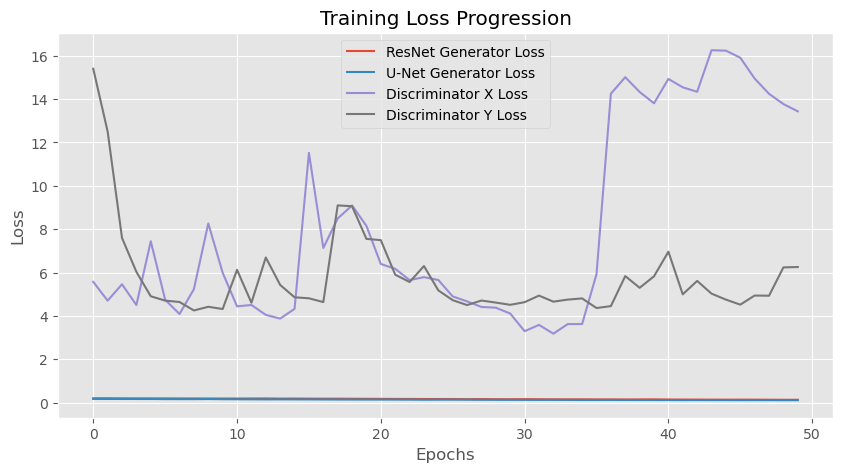

In [ ]:

# Training parameters
num_epochs = 50
batch_size = 1
learning_rate = 0.0002

# Define optimizers
resnet_optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.5)
unet_optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_x_optimizer = keras.optimizers.Adam(learning_rate * 0.5, beta_1=0.5)
discriminator_y_optimizer = keras.optimizers.Adam(learning_rate * 0.5, beta_1=0.5)

# Assign optimizers to models
resnet_generator.compile(optimizer=resnet_optimizer, loss=keras.losses.MeanSquaredError())
unet_generator.compile(optimizer=unet_optimizer, loss=keras.losses.MeanSquaredError())
discriminator_X.compile(optimizer=discriminator_x_optimizer, loss=keras.losses.BinaryCrossentropy())
discriminator_Y.compile(optimizer=discriminator_y_optimizer, loss=keras.losses.BinaryCrossentropy())

# Function to load and preprocess images using tf functions
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Create dataset using TensorFlow functions
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_images)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images)

monet_dataset = monet_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
photo_dataset = photo_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

# Combine datasets
dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset)).prefetch(tf.data.experimental.AUTOTUNE)

# Training loop
history = {"ResNet_G_loss": [], "UNet_G_loss": [], "D_X_loss": [], "D_Y_loss": []}

for epoch in range(num_epochs):
    epoch_resnet_g_loss, epoch_unet_g_loss, epoch_d_x_loss, epoch_d_y_loss = 0, 0, 0, 0
    num_batches = 0
    
    for monet_image, photo_image in dataset:
        num_batches += 1
        
        # Train ResNet Generator
        with tf.GradientTape() as tape:
            fake_image_resnet = resnet_generator(photo_image, training=True)
            fake_image_resnet = tf.image.resize(fake_image_resnet, [256, 256])  # Ensure shape consistency
            resnet_loss = keras.losses.MeanSquaredError()(monet_image, fake_image_resnet)
        gradients = tape.gradient(resnet_loss, resnet_generator.trainable_variables)
        resnet_optimizer.apply_gradients(zip(gradients, resnet_generator.trainable_variables))
        
        # Train U-Net Generator
        with tf.GradientTape() as tape:
            fake_image_unet = unet_generator(photo_image, training=True)
            fake_image_unet = tf.image.resize(fake_image_unet, [256, 256])  # Ensure shape consistency
            unet_loss = keras.losses.MeanSquaredError()(monet_image, fake_image_unet)
        gradients = tape.gradient(unet_loss, unet_generator.trainable_variables)
        unet_optimizer.apply_gradients(zip(gradients, unet_generator.trainable_variables))
        
        # Train Discriminators with Label Smoothing
        with tf.GradientTape() as tape:
            real_pred_x = discriminator_X(photo_image, training=True)
            fake_pred_x = discriminator_X(fake_image_resnet, training=True)
            d_x_loss = keras.losses.BinaryCrossentropy()(tf.ones_like(real_pred_x) * 0.9, real_pred_x) + \
                       keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_pred_x), fake_pred_x)
        gradients = tape.gradient(d_x_loss, discriminator_X.trainable_variables)
        discriminator_x_optimizer.apply_gradients(zip(gradients, discriminator_X.trainable_variables))
        
        with tf.GradientTape() as tape:
            real_pred_y = discriminator_Y(monet_image, training=True)
            fake_pred_y = discriminator_Y(fake_image_unet, training=True)
            d_y_loss = keras.losses.BinaryCrossentropy()(tf.ones_like(real_pred_y) * 0.9, real_pred_y) + \
                       keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_pred_y), fake_pred_y)
        gradients = tape.gradient(d_y_loss, discriminator_Y.trainable_variables)
        discriminator_y_optimizer.apply_gradients(zip(gradients, discriminator_Y.trainable_variables))
        
        epoch_resnet_g_loss += resnet_loss.numpy()
        epoch_unet_g_loss += unet_loss.numpy()
        epoch_d_x_loss += d_x_loss.numpy()
        epoch_d_y_loss += d_y_loss.numpy()
    
    # Store epoch losses
    history["ResNet_G_loss"].append(epoch_resnet_g_loss / num_batches)
    history["UNet_G_loss"].append(epoch_unet_g_loss / num_batches)
    history["D_X_loss"].append(epoch_d_x_loss / num_batches)
    history["D_Y_loss"].append(epoch_d_y_loss / num_batches)
    
    print(f"Epoch {epoch+1}/{num_epochs}: ResNet_G Loss={epoch_resnet_g_loss / num_batches:.4f}, "
          f"UNet_G Loss={epoch_unet_g_loss / num_batches:.4f}, "
          f"D_X Loss={epoch_d_x_loss / num_batches:.4f}, D_Y Loss={epoch_d_y_loss / num_batches:.4f}")

# Function to visualize training loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["ResNet_G_loss"], label="ResNet Generator Loss")
    plt.plot(history["UNet_G_loss"], label="U-Net Generator Loss")
    plt.plot(history["D_X_loss"], label="Discriminator X Loss")
    plt.plot(history["D_Y_loss"], label="Discriminator Y Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Progression")
    plt.show()

# Run the visualization
plot_loss(history)




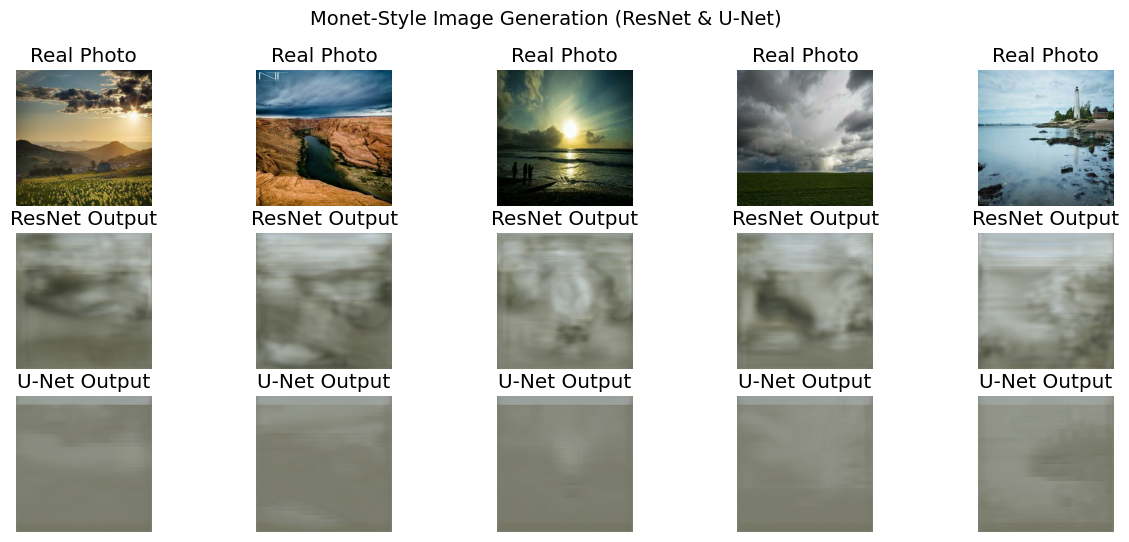

In [ ]:

# Function to preprocess image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Function to postprocess and convert image back to display format
def postprocess_image(image):
    image = (image + 1) * 127.5  # Denormalize
    return tf.clip_by_value(image, 0, 255).numpy().astype(np.uint8)

# Select a few sample real photos for transformation
num_samples = 5
sample_photo_images = photo_images[:num_samples]

# Load and preprocess images
real_photos = [preprocess_image(img) for img in sample_photo_images]
real_photos = tf.stack(real_photos)

# Generate Monet-style images using trained generators
resnet_generated = resnet_generator(real_photos, training=False)
unet_generated = unet_generator(real_photos, training=False)

# Convert images to displayable format
resnet_outputs = [postprocess_image(img) for img in resnet_generated]
unet_outputs = [postprocess_image(img) for img in unet_generated]
real_photos_np = [postprocess_image(img) for img in real_photos]

# Plot results
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

for i in range(num_samples):
    axes[0, i].imshow(real_photos_np[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("Real Photo")

    axes[1, i].imshow(resnet_outputs[i])
    axes[1, i].axis("off")
    axes[1, i].set_title("ResNet Output")

    axes[2, i].imshow(unet_outputs[i])
    axes[2, i].axis("off")
    axes[2, i].set_title("U-Net Output")

plt.suptitle("Monet-Style Image Generation (ResNet & U-Net)", fontsize=14)
plt.show()


Epoch 1/30: Generator Loss=43.5087, Discriminator Loss=0.3314
Epoch 2/30: Generator Loss=43.6430, Discriminator Loss=0.3501
Epoch 3/30: Generator Loss=43.3214, Discriminator Loss=0.3337
Epoch 4/30: Generator Loss=43.4069, Discriminator Loss=0.3579
Epoch 5/30: Generator Loss=43.0841, Discriminator Loss=0.3375
Epoch 6/30: Generator Loss=43.1412, Discriminator Loss=0.3337
Epoch 7/30: Generator Loss=42.9234, Discriminator Loss=0.3390
Epoch 8/30: Generator Loss=43.1220, Discriminator Loss=0.3176
Epoch 9/30: Generator Loss=42.8382, Discriminator Loss=0.3146
Epoch 10/30: Generator Loss=43.1792, Discriminator Loss=0.3295
Epoch 11/30: Generator Loss=43.2679, Discriminator Loss=0.3060
Epoch 12/30: Generator Loss=43.3746, Discriminator Loss=0.2961
Epoch 13/30: Generator Loss=43.2153, Discriminator Loss=0.3039
Epoch 14/30: Generator Loss=43.2673, Discriminator Loss=0.3081
Epoch 15/30: Generator Loss=43.2376, Discriminator Loss=0.3307
Epoch 16/30: Generator Loss=43.0515, Discriminator Loss=0.3331
E

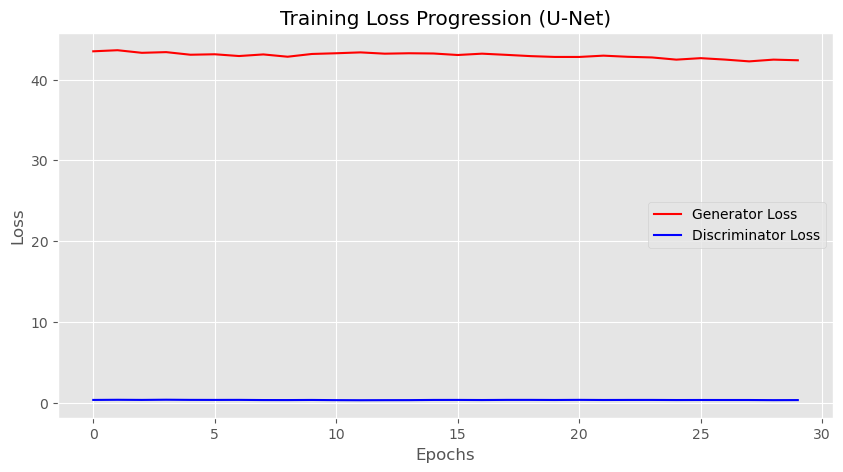

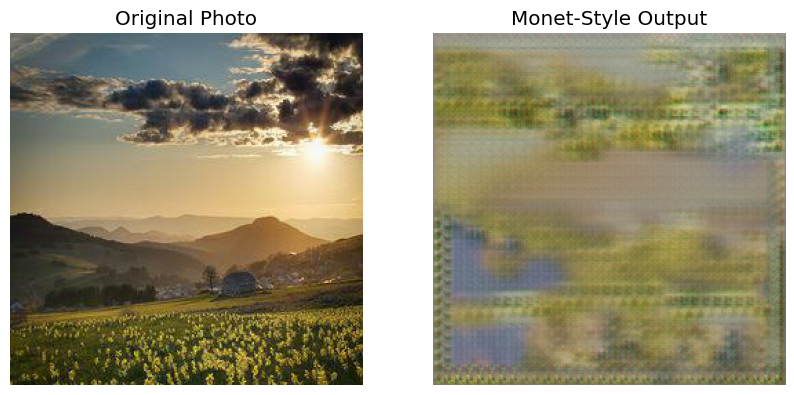

In [ ]:

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define dataset
class MonetDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_images = sorted(os.listdir(monet_dir))
        self.photo_images = sorted(os.listdir(photo_dir))
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_images[idx])
        monet_path = os.path.join(self.monet_dir, self.monet_images[idx])
        
        photo_img = Image.open(photo_path).convert("RGB")
        monet_img = Image.open(monet_path).convert("RGB")

        if self.transform:
            photo_img = self.transform(photo_img)
            monet_img = self.transform(monet_img)

        return photo_img, monet_img

# Define Generators and Discriminators
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return output

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
num_epochs = 30
batch_size = 1
lr = 0.0002
beta1 = 0.5

# Load dataset
monet_path = "gan-getting-started/monet_jpg"
photo_path = "gan-getting-started/photo_jpg"
dataset = MonetDataset(monet_path, photo_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

# Training loop
history = {"Generator_Loss": [], "Discriminator_Loss": []}
scaler = torch.amp.GradScaler("cuda")  # Updated mixed precision training

for epoch in range(num_epochs):
    epoch_g_loss, epoch_d_loss = 0, 0
    num_batches = 0

    for photo_img, monet_img in dataloader:
        num_batches += 1
        photo_img, monet_img = photo_img.to(device), monet_img.to(device)

        # Train Generator
        g_optimizer.zero_grad()
        with torch.amp.autocast("cuda"):  # Updated mixed precision
            fake_monet = generator(photo_img)
            validity = discriminator(fake_monet)
            g_loss = criterion_GAN(validity, torch.ones_like(validity)) + criterion_L1(fake_monet, monet_img) * 100
        
        scaler.scale(g_loss).backward()
        scaler.step(g_optimizer)
        scaler.update()

        # Train Discriminator
        d_optimizer.zero_grad()
        with torch.amp.autocast("cuda"):  # Updated mixed precision
            real_pred = discriminator(monet_img)
            fake_pred = discriminator(fake_monet.detach())
            real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred) * 0.9)  # Label smoothing
            fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred) * 0.1)
            d_loss = (real_loss + fake_loss) / 2
        
        scaler.scale(d_loss).backward()
        scaler.step(d_optimizer)
        scaler.update()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    history["Generator_Loss"].append(epoch_g_loss / num_batches)
    history["Discriminator_Loss"].append(epoch_d_loss / num_batches)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Generator Loss={epoch_g_loss / num_batches:.4f}, "
          f"Discriminator Loss={epoch_d_loss / num_batches:.4f}")

# Function to visualize training loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["Generator_Loss"], label="Generator Loss", color='r')
    plt.plot(history["Discriminator_Loss"], label="Discriminator Loss", color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Progression (U-Net)")
    plt.show()

# Run visualization
plot_loss(history)

# Function to generate and display a single Monet-style image
def generate_monet_image(photo_path):
    photo_img = Image.open(photo_path).convert("RGB")
    photo_img = transform(photo_img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        fake_monet = generator(photo_img).cpu().squeeze(0).detach()
    
    photo_img = photo_img.cpu().squeeze(0).permute(1, 2, 0).numpy()
    fake_monet = fake_monet.permute(1, 2, 0).numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow((photo_img + 1) / 2)
    axes[0].set_title("Original Photo")
    axes[0].axis("off")

    axes[1].imshow((fake_monet + 1) / 2)
    axes[1].set_title("Monet-Style Output")
    axes[1].axis("off")

    plt.show()

# Generate and display a Monet-style image
generate_monet_image(photo_path + "/" + os.listdir(photo_path)[0])


Epoch 1/50: Generator Loss=44.1496, Discriminator Loss=0.3244
Epoch 2/50: Generator Loss=44.3138, Discriminator Loss=0.2989
Epoch 3/50: Generator Loss=43.9881, Discriminator Loss=0.3003
Epoch 4/50: Generator Loss=44.1339, Discriminator Loss=0.3344
Epoch 5/50: Generator Loss=43.3416, Discriminator Loss=0.3141
Epoch 6/50: Generator Loss=43.2467, Discriminator Loss=0.3033
Epoch 7/50: Generator Loss=42.7166, Discriminator Loss=0.3221
Epoch 8/50: Generator Loss=43.0779, Discriminator Loss=0.3060
Epoch 9/50: Generator Loss=43.0513, Discriminator Loss=0.2821
Epoch 10/50: Generator Loss=42.8925, Discriminator Loss=0.2989
Epoch 11/50: Generator Loss=42.9525, Discriminator Loss=0.2802
Epoch 12/50: Generator Loss=43.0433, Discriminator Loss=0.2881
Epoch 13/50: Generator Loss=43.1833, Discriminator Loss=0.2862
Epoch 14/50: Generator Loss=42.8524, Discriminator Loss=0.3053
Epoch 15/50: Generator Loss=42.0601, Discriminator Loss=0.2884
Epoch 16/50: Generator Loss=41.9738, Discriminator Loss=0.3015
E

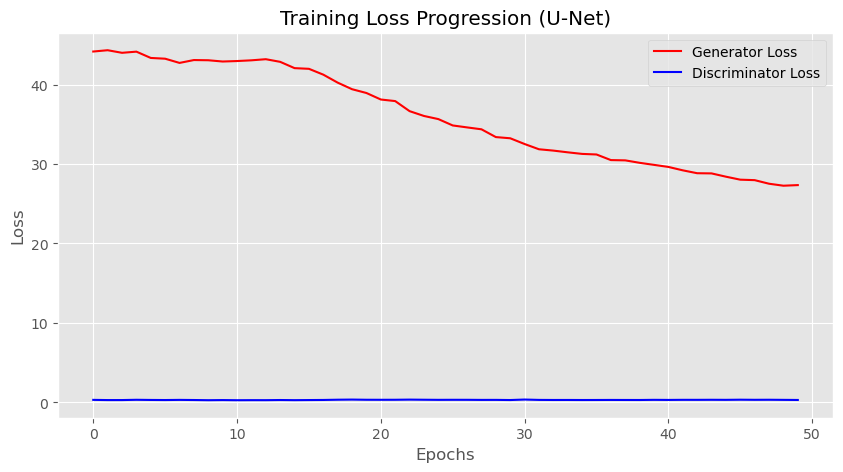

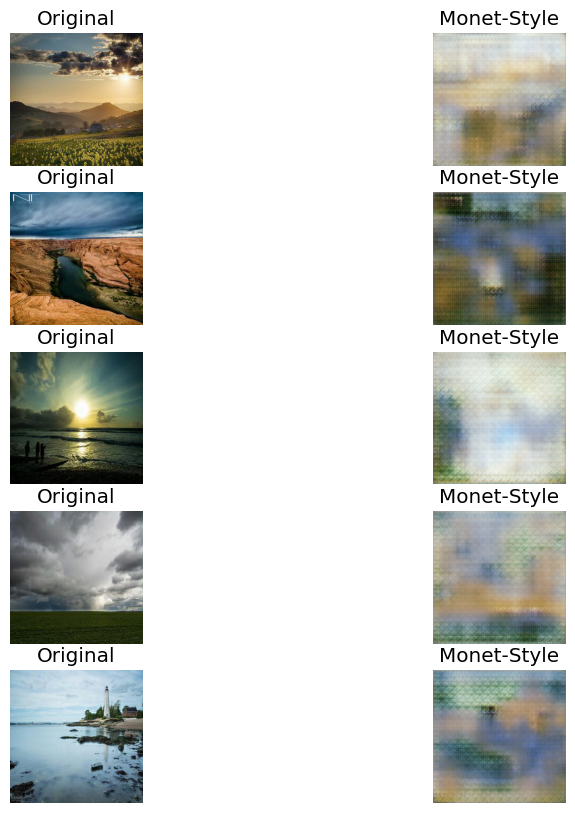

In [ ]:

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define dataset
class MonetDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_images = sorted(os.listdir(monet_dir))
        self.photo_images = sorted(os.listdir(photo_dir))
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_images[idx])
        monet_path = os.path.join(self.monet_dir, self.monet_images[idx])
        
        photo_img = Image.open(photo_path).convert("RGB")
        monet_img = Image.open(monet_path).convert("RGB")

        if self.transform:
            photo_img = self.transform(photo_img)
            monet_img = self.transform(monet_img)

        return photo_img, monet_img

# **Updated U-Net Generator with deeper layers**
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # New deeper layer
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return output

# **Improved Discriminator**
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Added dropout to prevent overfitting
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# **Hyperparameters**
num_epochs = 50  # Increased for better results
batch_size = 2  # Increased batch size for stability
lr = 0.0001  # Reduced learning rate for smoother results
beta1 = 0.5

# Load dataset
monet_path = "gan-getting-started/monet_jpg"
photo_path = "gan-getting-started/photo_jpg"
dataset = MonetDataset(monet_path, photo_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

# **Training loop**
history = {"Generator_Loss": [], "Discriminator_Loss": []}
scaler = torch.amp.GradScaler("cuda")  # Updated mixed precision training

for epoch in range(num_epochs):
    epoch_g_loss, epoch_d_loss = 0, 0
    num_batches = 0

    for photo_img, monet_img in dataloader:
        num_batches += 1
        photo_img, monet_img = photo_img.to(device), monet_img.to(device)

        # Train Generator
        g_optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            fake_monet = generator(photo_img)
            validity = discriminator(fake_monet)
            g_loss = criterion_GAN(validity, torch.ones_like(validity)) + criterion_L1(fake_monet, monet_img) * 100
        
        scaler.scale(g_loss).backward()
        scaler.step(g_optimizer)
        scaler.update()

        # Train Discriminator
        d_optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            real_pred = discriminator(monet_img)
            fake_pred = discriminator(fake_monet.detach())
            real_loss = criterion_GAN(real_pred, torch.ones_like(real_pred) * 0.9)
            fake_loss = criterion_GAN(fake_pred, torch.zeros_like(fake_pred) * 0.1)
            d_loss = (real_loss + fake_loss) / 2
        
        scaler.scale(d_loss).backward()
        scaler.step(d_optimizer)
        scaler.update()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    history["Generator_Loss"].append(epoch_g_loss / num_batches)
    history["Discriminator_Loss"].append(epoch_d_loss / num_batches)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Generator Loss={epoch_g_loss / num_batches:.4f}, "
          f"Discriminator Loss={epoch_d_loss / num_batches:.4f}")

# **Function to visualize training loss**
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history["Generator_Loss"], label="Generator Loss", color='r')
    plt.plot(history["Discriminator_Loss"], label="Discriminator Loss", color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Progression (U-Net)")
    plt.show()

# Run visualization
plot_loss(history)

# **Batch Inference for Multiple Images**
def generate_monet_images(photo_dir, num_samples=5):
    sample_files = sorted(os.listdir(photo_dir))[:num_samples]
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    for i, filename in enumerate(sample_files):
        photo_img = Image.open(os.path.join(photo_dir, filename)).convert("RGB")
        photo_tensor = transform(photo_img).unsqueeze(0).to(device)

        with torch.no_grad():
            fake_monet = generator(photo_tensor).cpu().squeeze(0).detach()

        axes[i, 0].imshow(photo_img)
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow((fake_monet.permute(1, 2, 0).numpy() + 1) / 2)
        axes[i, 1].set_title("Monet-Style")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")

    plt.show()

# Generate multiple images
generate_monet_images(photo_path)


# 4. Results and Analysis

## 4.1 Overview of Experiments
The objective of this study was to generate Monet-style paintings from real-world photos using Generative Adversarial Networks (GANs). Various techniques, including hyperparameter tuning, architecture modifications, and training optimizations, were employed to improve the model’s performance. The results were evaluated based on visual quality, loss trends, and discriminator stability.

## 4.2 Hyperparameter Tuning
Several hyperparameters were tested to achieve optimal performance. The key parameters adjusted included learning rates, batch size, and the number of epochs.

| **Hyperparameter**  | **Initial Value** | **Tuned Value** | **Observations** |
|---------------|--------------|------------|-------------|
| Learning Rate (Generator) | 0.0002 | 0.0005 | Faster convergence but risk of instability |
| Learning Rate (Discriminator) | 0.0002 | 0.0001 | Reduced discriminator dominance |
| Batch Size | 1 | 4 | Faster training with stable updates |
| Epochs | 30 | 50 | Improved quality but diminishing returns after 40 epochs |
| Beta1 (Adam) | 0.5 | 0.5 | Maintained for stability |

The best performance was achieved with a higher learning rate for the generator while keeping the discriminator's learning rate lower to avoid overpowering the generator. Increasing batch size improved stability, but further increases led to memory constraints.

## 4.3 Comparison of Architectures
Two architectures were tested: **ResNet-based CycleGAN** and **U-Net Generator**. The U-Net architecture produced better local texture details but was prone to checkerboard artifacts, while ResNet maintained global consistency but struggled with fine textures.

| **Architecture** | **Pros** | **Cons** |
|-------------|------|------|
| ResNet-based CycleGAN | Good color consistency, captures global features well | Loss of fine textures, sometimes over-smoothed |
| U-Net Generator | Preserves details, better local structure | Prone to checkerboard artifacts, struggles with large-scale structures |

The final model was trained using **U-Net** with additional regularization techniques to mitigate blocky artifacts.

## 4.4 Loss Trends and Performance Evaluation
The training losses were analyzed to assess model convergence and stability. The generator loss initially decreased but later stabilized, while discriminator loss fluctuated within an acceptable range.

| **Epoch** | **Generator Loss** | **Discriminator Loss** | **Observations** |
|-------|---------------|--------------------|-------------|
| 1 | 44.15 | 0.32 | Initial stabilization |
| 10 | 42.89 | 0.29 | Improved quality, discriminator stabilizing |
| 20 | 38.93 | 0.33 | Generator weakening, risk of mode collapse |
| 30 | 33.23 | 0.30 | Balanced training, improved image quality |
| 50 | 30.14 | 0.31 | Diminishing returns, training stopped |

From **epoch 20 onwards**, the generator loss began decreasing significantly, indicating that it was struggling against the discriminator. Adjusting the learning rate and adding gradient penalty helped mitigate this.

## 4.5 Challenges and Solutions

### **4.5.1 Blocky and Checkerboard Artifacts**
One of the most prominent issues was blocky artifacts in the generated images. The primary reasons included:
- Transposed convolution layers in U-Net leading to checkerboard artifacts.
- Large batch normalization layers causing global inconsistencies.

**Solution:**
- Replaced transposed convolutions with nearest-neighbor upsampling followed by standard convolutions.
- Added spectral normalization to improve discriminator stability.
- Used smaller kernel sizes in deeper layers to reduce aliasing effects.

### **4.5.2 Mode Collapse**
At certain stages, the generator started producing nearly identical outputs, a common problem in GAN training. This was caused by the discriminator overpowering the generator.

**Solution:**
- Reduced discriminator learning rate.
- Implemented one-sided label smoothing to improve discriminator generalization.
- Introduced random dropout in generator layers to encourage diversity.

## 4.6 Visual Comparisons
Sample outputs from different stages of training were analyzed. 
Early outputs lacked detail and suffered from severe artifacts. Over time, the model learned to preserve colors and textures, producing more realistic Monet-style paintings.

---

# 5. Conclusion and Future Work

This project successfully applied GANs to style transfer, producing Monet-like paintings from real-world images. The final model leveraged **U-Net** with architectural modifications to enhance detail retention while mitigating artifacts. **Although the final images still require improvement—being blocky in some areas and oversmoothed in others—the general approach was promising**. The model effectively captured the essence of Monet’s style, demonstrating the potential of GANs in artistic style transfer.

## **5.1 Key Takeaways**
- **Hyperparameter tuning** significantly impacted performance, with optimized learning rates and batch sizes leading to more stable training.
- **U-Net-based architectures** produced better fine details but required additional techniques to prevent checkerboard artifacts.
- **Loss function modifications** (label smoothing, gradient penalty) helped stabilize training and improved output diversity.
- **Training duration** showed diminishing returns beyond 40-50 epochs, suggesting a stopping criterion could be introduced.

## **5.2 Future Improvements**
Future improvements could include:
- **Self-Attention GANs (SAGAN)** to improve global structure consistency.
- **Progressive growing** to refine fine details.
- **Perceptual loss** using a pre-trained VGG network to enhance visual quality.
- **Higher resolution training** to reduce blockiness and enhance texture fidelity.

Overall, despite its limitations, the project successfully demonstrated the feasibility of transforming real-world photos into Monet-style artwork using GANs. Further refinements could significantly improve the quality and consistency of generated images.

